In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import *
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from hmm_utils import *
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA



min_nblocks    = 3          # min number of blocks for a session to be include
max_ndays      = 1e23
#min_R2         = 0.1

files          = glob.glob('D:/T5_ClosedLoop/*')
sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()
sessions       = get_Sessions(files, min_nblocks)  # get T5 sessions      

pairs          = get_SessionPairs(files, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
#pairs, scores = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs       = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_frac      = 0.5
sigma           = None

angles          = np.zeros((n_pairs, 2))
scores          = np.zeros((n_pairs, 2))
diffs           = np.zeros((n_pairs))

for i, (A_file, B_file) in enumerate(pairs):  
    dayA, dayB              = DataStruct(A_file, alignScreens = True), DataStruct(B_file, alignScreens = True)
    diffs[i]                = daysBetween(dayA.date, dayB.date) # record number of days between sessions

    dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)

    # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, blocks = dayA_blocks, task = dayA_task, return_flattened = True)
    Btrain_x, Btest_x, Btrain_y, Btest_y  = getTrainTest(dayB, train_frac = train_frac, sigma = sigma, blocks = dayB_blocks, task = dayB_task, return_flattened = True)
    
    Atrain_x -= Atrain_x.mean(axis = 0)
    Btrain_x -= Btrain_x.mean(axis = 0)
    Atest_x  -= Atest_x.mean(axis = 0)
    Btest_x  -= Btest_x.mean(axis = 0)
    
    A_score, A_decoder    = traintest_DecoderSupervised([Atrain_x], [Atest_x], [Atrain_y], [Atest_y], meanRecal = False)           # evaluate training set mean performance 
    B_score, B_decoder    = traintest_DecoderSupervised([Btrain_x], [Btest_x], [Btrain_y], [Btest_y], meanRecal = False)           # evaluate training set mean performance 

    for j in range(2):
        angles[i, j]     = angle_between(A_decoder.coef_[j, :], B_decoder.coef_[j, :])
        
    scores[i, 0] = A_score[0]
    scores[i, 1] = B_score[0]
    

Text(0.5, 1.0, 'Angle between mean-adjusted velocity decoders')

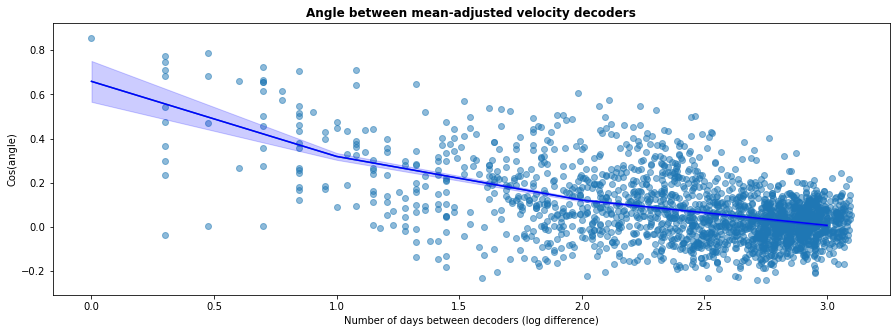

In [59]:
n_iters = 1000

subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
x         = np.log10(diffs[subselect])
y         = np.cos(angles[subselect, 0])

figSize(5, 15)
plt.scatter(x, y, alpha = 0.5)
poly = np.poly1d(np.polyfit(x, y, deg = 3))
plt.plot(np.arange(max(x)), poly(np.arange(max(x))))


bootstrap_CI = np.zeros((len(np.arange(max(x))), n_iters))

for i in range(n_iters):
    bs_inds = np.random.choice(len(x), len(x), replace = True)
    poly    = np.poly1d(np.polyfit(x[bs_inds], y[bs_inds], deg = 3))
    
    bootstrap_CI[:, i] = poly(np.arange(max(x)))
       
plotsd(bootstrap_CI.T, time_bins= np.arange(max(x)), color = 'b')
plt.xlabel('Number of days between decoders (log difference)')
plt.ylabel('Cos(angle)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')


In [33]:
var_x

0.027320154320274584